In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale, robust_scale
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
%matplotlib inline
# %matplotlib tk

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm

# 데이터 구성하기 - 콘크리트
데이터를 ( train(0.4) : validation(0.3) : test(0.3) )의 비율로 분할했습니다

In [4]:
df_raw = pd.read_csv("Concrete.csv", engine = "python")
df_raw_y = df_raw["CONCRETE_COMPRESSIVE_STRENGTH"]
df_raw_x = df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis = 1, inplace = False)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234)
df_train_x, df_validation_x, df_train_y, df_validation_y = train_test_split(df_train_x, df_train_y, test_size = 0.428, random_state = 1234)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))

print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

print("validation data X size : {}".format(df_validation_x.shape))
print("validation data Y size : {}".format(df_validation_y.shape))


train data X size : (412, 8)
train data Y size : (412,)
test data X size : (309, 8)
test data Y size : (309,)
validation data X size : (309, 8)
validation data Y size : (309,)


# 기본 모델 생성

In [5]:
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x,df_train_y)
print("Score on training set:{:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set:{:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set:0.957
Score on test set:0.874


In [6]:
gb_uncustomized

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1234, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# 트리 수(n_estimator) 변경에 따른 모델

In [7]:
train_score = []
val_score = []
para_n_tree = [n_tree * 10 for n_tree in range(1,30)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=v_n_estimators)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    val_score.append(gb.score(df_validation_x,df_validation_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["Validation_Score"] = val_score

df_score_n.round(3)


,n_estimators,TrainScore,Validation_Score
0,10,0.666,0.565
1,20,0.827,0.718
2,30,0.885,0.781
3,40,0.911,0.804
4,50,0.926,0.815
5,60,0.936,0.823
6,70,0.943,0.831
7,80,0.948,0.833
8,90,0.953,0.837
9,100,0.957,0.838


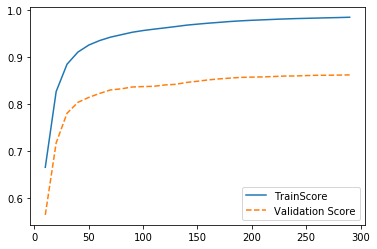

In [8]:
plt.plot(para_n_tree, train_score, linestyle = "-", label="TrainScore")
plt.plot(para_n_tree, val_score, linestyle = "--", label="Validation Score")
plt.legend()

# 잎사귀 노드의 최소 자료수에 따른 모델

In [9]:
train_score = []
val_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=100,min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    val_score.append(gb.score(df_validation_x,df_validation_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamlesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["Validation Score"] = val_score


df_score_leaf.round(3)

,MinSamlesLeaf,TrainScore,Validation Score
0,1,0.957,0.838
1,2,0.956,0.843
2,3,0.956,0.849
3,4,0.957,0.847
4,5,0.957,0.850
5,6,0.953,0.849
6,7,0.952,0.852
7,8,0.952,0.844
8,9,0.950,0.854
9,10,0.950,0.846


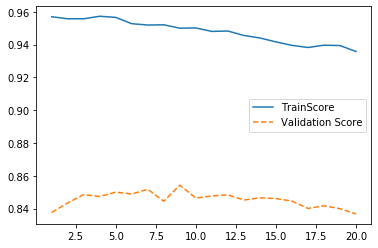

In [10]:
plt.plot(para_leaf, train_score, linestyle = "-", label="TrainScore")
plt.plot(para_leaf, val_score, linestyle = "--", label="Validation Score")
plt.legend()

# 분리 노드의 최소 자료수에 따른 모델

In [11]:
train_score = []
val_score = []
para_split = [n_split * 2 for n_split in range(5,21)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=100,min_samples_leaf=9,min_samples_split=v_min_samples_split)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    val_score.append(gb.score(df_validation_x,df_validation_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamlesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["Validation Score"] = val_score
df_score_split.round(3)



,MinSamlesSplit,TrainScore,Validation Score
0,10,0.950,0.854
1,12,0.950,0.854
2,14,0.950,0.854
3,16,0.950,0.854
4,18,0.950,0.854
5,20,0.947,0.854
6,22,0.947,0.851
7,24,0.948,0.853
8,26,0.947,0.851
9,28,0.947,0.850


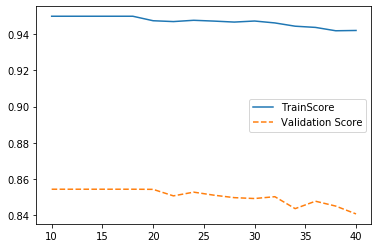

In [12]:
plt.plot(para_split, train_score, linestyle = "-", label="TrainScore")
plt.plot(para_split, val_score, linestyle = "--", label="Validation Score")
plt.legend()

# 최대 깊이 변경에 따른 모델

In [13]:
train_score = []
val_score = []
para_depth = [depth for depth in range(1,21)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=100,min_samples_leaf=9,
                                 min_samples_split=18,max_depth=v_max_depth)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    val_score.append(gb.score(df_validation_x,df_validation_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["Validation Score"] = val_score
df_score_depth.round(3)



,Depth,TrainScore,Validation Score
0,1,0.839,0.755
1,2,0.906,0.828
2,3,0.950,0.854
3,4,0.972,0.858
4,5,0.983,0.847
5,6,0.988,0.852
6,7,0.990,0.849
7,8,0.991,0.848
8,9,0.993,0.846
9,10,0.994,0.844


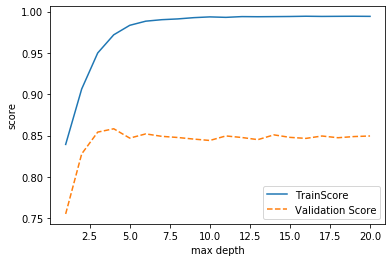

In [14]:
plt.plot(para_depth, train_score, linestyle = "-", label="TrainScore")
plt.plot(para_depth, val_score, linestyle = "--", label="Validation Score")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

# 학습률 변경에 따른 모델

In [15]:
train_score = []
val_score = []
para_lr = [lr*0.1 for lr in range(1,10)]
# 12,18
for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=100,min_samples_leaf=9,
                                 min_samples_split=18,max_depth=4,learning_rate = v_learning_rate)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    val_score.append(gb.score(df_validation_x,df_validation_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["LearningRate"] = para_lr
df_score_depth["TrainScore"] = train_score
df_score_depth["Validation Score"] = val_score
df_score_depth.round(3)



,LearningRate,TrainScore,Validation Score
0,0.1,0.972,0.858
1,0.2,0.984,0.850
2,0.3,0.989,0.851
3,0.4,0.993,0.877
4,0.5,0.995,0.869
5,0.6,0.996,0.853
6,0.7,0.997,0.852
7,0.8,0.997,0.834
8,0.9,0.997,0.800


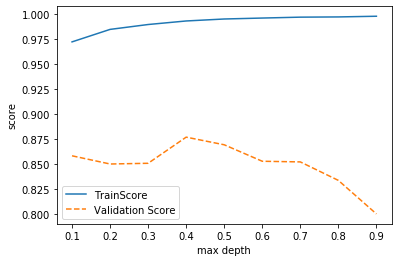

In [16]:
plt.plot(para_lr, train_score, linestyle = "-", label="TrainScore")
plt.plot(para_lr, val_score, linestyle = "--", label="Validation Score")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [17]:
train_score = []
val_score = []
para_lr = [lr*0.01 for lr in range(30,50)]
# 12,18
for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=100,min_samples_leaf=9,
                                 min_samples_split=18,max_depth=4,learning_rate = v_learning_rate)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    val_score.append(gb.score(df_validation_x,df_validation_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["LearningRate"] = para_lr
df_score_depth["TrainScore"] = train_score
df_score_depth["Validation Score"] = val_score
df_score_depth.round(3)



,LearningRate,TrainScore,Validation Score
0,0.30,0.989,0.851
1,0.31,0.990,0.845
2,0.32,0.991,0.847
3,0.33,0.989,0.850
4,0.34,0.991,0.849
5,0.35,0.991,0.856
6,0.36,0.992,0.862
7,0.37,0.992,0.853
8,0.38,0.993,0.851
9,0.39,0.992,0.862


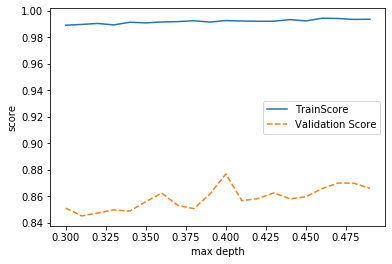

In [18]:
plt.plot(para_lr, train_score, linestyle = "-", label="TrainScore")
plt.plot(para_lr, val_score, linestyle = "--", label="Validation Score")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [19]:
train_score = []
val_score = []
para_lr = [lr*0.001 for lr in range(400,420)]
# 12,18
for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=1234, n_estimators=100,min_samples_leaf=9,
                                 min_samples_split=18,max_depth=4,learning_rate = v_learning_rate)
    gb.fit(df_train_x,df_train_y)
    train_score.append(gb.score(df_train_x,df_train_y))
    val_score.append(gb.score(df_validation_x,df_validation_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["LearningRate"] = para_lr
df_score_depth["TrainScore"] = train_score
df_score_depth["Validation Score"] = val_score
df_score_depth.round(3)



,LearningRate,TrainScore,Validation Score
0,0.400,0.993,0.877
1,0.401,0.992,0.880
2,0.402,0.992,0.875
3,0.403,0.993,0.880
4,0.404,0.992,0.871
5,0.405,0.993,0.861
6,0.406,0.992,0.868
7,0.407,0.992,0.864
8,0.408,0.992,0.864
9,0.409,0.991,0.865


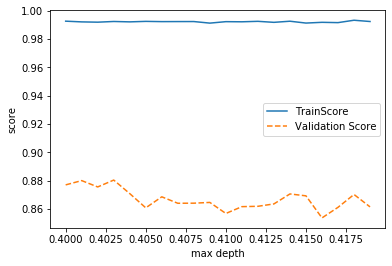

In [20]:
plt.plot(para_lr, train_score, linestyle = "-", label="TrainScore")
plt.plot(para_lr, val_score, linestyle = "--", label="Validation Score")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

# 최종 모델 선정

In [24]:
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators=100,min_samples_leaf=9,
                                 min_samples_split=18,max_depth=4,learning_rate = 0.414)
gb_final.fit(df_train_x, df_train_y)

print("Score on training set:{:.3f}".format(gb_final.score(df_train_x,df_train_y)))
print("Score on test set:{:.3f}".format(gb_final.score(df_test_x,df_test_y)))

gb_final


Score on training set:0.993
Score on test set:0.897


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.414, loss='ls',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=18,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1234, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
result = gb_final.predict(df_test_x)
mse = mean_squared_error(result, df_test_y)
mae = mean_absolute_error(result, df_test_y)

print("mse : ",mse.round(3))
print("mae : ",mae.round(3))


mse :  26.882
mae :  3.64


Text(0, 0.5, '변수')

/home/pirl/anaconda3/envs/NLP_env/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/envs/NLP_env/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/envs/NLP_env/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/envs/NLP_env/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/envs/NLP_env/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/pirl/anaconda3/envs/NLP_

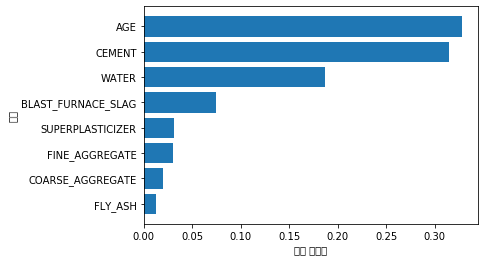

In [26]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

# 결론
의사결정나무 모델의 정확도는 다음과 같습니다.  

Score on training set:0.948  

Score on test set:0.761  

mse :  62.177  

mae :  5.887  


랜덤 포레스트 모델의 정확도는 다음과 같습니다.  

Score on training set:0.933  

Score on test set:0.833  

mse :  43.504  

mae :  5.227  

그래디언트 부스팅 모델의 정확도는 다음과 같습니다.  

Score on training set:0.993  

Score on test set:0.897  

mse :  26.882  

mae :  3.64  

의사결정 나무와 랜덤 포레스트, 그래디언트 부스팅 모델 모두 설명변수의 중요도가 AGE가 가장크고 그 다음이 CEMENT와 WATER 입니다.  

세 모델을 비교한 결과 그래디언트 부스팅 모델의 정확도가 89.7%로 가장 큰 정확도를 보입니다. mse와 mae의 값도 세 모델 중 가장 작아서 랜덤 포레스트 모델이 더 적합한 모델이라고 할 수 있습니다.  

training정확도가 90%가 넘고 test정확도가 90%에 가까우므로 현업에서도 사용할 수 있을 것이라 생각합니다.